In [122]:
import copy

from rtdl import MLP
from catboost import CatBoostClassifier
import optuna
import pytorch_lightning as pl 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchmetrics.functional as metric_f
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [162]:
sns.set(font_scale=2)
# sns.set_context("paper", rc={"font.size":30, "axes.titlesize":16, "axes.labelsize":10})  

# Загрузка данных

In [2]:
train_data = pd.read_csv("../data/my_ready_dataset.csv")
train_targets = pd.read_csv("../data/my_ready_targets.csv")

/var/folders/n5/zftt7r7n09j715hq4n1wqyjmmqxvb8/T/ipykernel_92673/1286203582.py:1: DtypeWarning: Columns (1173) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("../data/my_ready_dataset.csv")


In [3]:
train_data.shape, train_targets.shape

((365162, 1228), (365162, 10))

In [4]:
train_data.shape, train_targets.shape

((365162, 1228), (365162, 10))

In [5]:
train_percent = 0.75
val_percent = 0.1

x_train_list = []
x_val_list = []
x_test_list = []

y_train_list = []
y_val_list = []
y_test_list = []

for key, data in train_data.groupby("station_id"):
    targets = train_targets[train_targets.station_id == key]
    data.sort_values("local_time", inplace=True)
    targets.sort_values("local_time", inplace=True)
    
    train_size = int(len(data) * train_percent)
    val_size = int(len(data) * val_percent)
    test_size = len(data) - train_size - val_size
     
    x_train_list.append(data.iloc[:train_size])
    y_train_list.append(targets.iloc[:train_size])
    
    x_val_list.append(data.iloc[train_size:train_size + val_size])
    y_val_list.append(targets.iloc[train_size:train_size + val_size])

    x_test_list.append(data.iloc[train_size + val_size:])
    y_test_list.append(targets.iloc[train_size + val_size:])

/var/folders/n5/zftt7r7n09j715hq4n1wqyjmmqxvb8/T/ipykernel_92673/2561346841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets.sort_values("local_time", inplace=True)


In [75]:
labels = list(train_targets.columns)
labels.remove("local_time")
labels.remove("station_id")
labels

['VETER', 'SHKVAL', 'METEL', 'DOZD', 'SNEG', 'GRAD', 'TUMAN', 'GOLOLED']

In [7]:
X_train = pd.concat(x_train_list, ignore_index=True).drop(columns=["local_time", "station_id"]).fillna(0)
y_train = pd.concat(y_train_list, ignore_index=True)[labels].values.astype(int)

X_val = pd.concat(x_val_list, ignore_index=True).drop(columns=["local_time", "station_id"]).fillna(0)
y_val = pd.concat(y_val_list, ignore_index=True)[labels].values.astype(int)

X_test = pd.concat(x_test_list, ignore_index=True).drop(columns=["local_time", "station_id"]).fillna(0)
y_test = pd.concat(y_test_list, ignore_index=True)[labels].values.astype(int)

In [8]:
pd.concat(x_test_list, ignore_index=True).fillna(0).to_csv("X_test_raw.csv", index=False)

In [9]:
numeric_features = []
categorial_features = []

truncated = X_train.iloc[:10]


for col in tqdm(truncated.columns):
    try:
        truncated[col].mean()
        numeric_features.append(col)
    except:
        categorial_features.append(col)

print(len(numeric_features))
print(len(categorial_features))

for col in categorial_features:
    for X in [X_train, X_val, X_test]:
        X[col] = X[col].astype(str)

# for col in tqdm(numeric_features):
    # for X in [X_train, X_val, X_test]:
    #     X[col] = X[col].astype(float)

  0%|          | 0/1226 [00:00<?, ?it/s]

1220
6


# CatBoost

In [169]:
base_model = CatBoostClassifier(loss_function="MultiLogloss", iterations=100)

In [170]:
base_model.fit(
    X_train, 
    y_train, 
    cat_features=categorial_features, 
    eval_set=(X_val, y_val), 
    verbose=1,
)

Learning rate set to 0.345129
0:	learn: 0.2300946	test: 0.2350478	best: 0.2350478 (0)	total: 2.08s	remaining: 3m 26s
1:	learn: 0.1388271	test: 0.1428187	best: 0.1428187 (1)	total: 3.99s	remaining: 3m 15s
2:	learn: 0.1127090	test: 0.1158767	best: 0.1158767 (2)	total: 5.76s	remaining: 3m 6s
3:	learn: 0.1023809	test: 0.1046947	best: 0.1046947 (3)	total: 7.54s	remaining: 3m 1s
4:	learn: 0.0974075	test: 0.0994861	best: 0.0994861 (4)	total: 9.25s	remaining: 2m 55s
5:	learn: 0.0941485	test: 0.0960097	best: 0.0960097 (5)	total: 11.1s	remaining: 2m 53s
6:	learn: 0.0922330	test: 0.0938692	best: 0.0938692 (6)	total: 12.8s	remaining: 2m 49s
7:	learn: 0.0909698	test: 0.0925892	best: 0.0925892 (7)	total: 14.5s	remaining: 2m 46s
8:	learn: 0.0891614	test: 0.0909736	best: 0.0909736 (8)	total: 16.3s	remaining: 2m 44s
9:	learn: 0.0877971	test: 0.0896445	best: 0.0896445 (9)	total: 18s	remaining: 2m 41s
10:	learn: 0.0866385	test: 0.0883335	best: 0.0883335 (10)	total: 19.7s	remaining: 2m 39s
11:	learn: 0.08

In [171]:
base_model.best_score_["validation"]["MultiLogloss"]

0.07762463519093796

In [172]:
feature_importances = base_model.feature_importances_

good_features = []
bad_features = []

for index, feature in enumerate(X_train.columns):
    if feature_importances[index] == 0.0:
        bad_features.append(feature)
    else:
        good_features.append(feature)

In [173]:
len(good_features), len(bad_features)

(201, 1025)

In [10]:
good_features = ['T_median_window=8',
 'T_max_window=8',
 'Po_mean_window=8',
 'Po_skew_window=8',
 'Po_min_window=8',
 'Po_max_window=8',
 'P_mean_window=8',
 'P_std_window=8',
 'P_mad_window=8',
 'P_skew_window=8',
 'P_min_window=8',
 'P_max_window=8',
 'Pa_mean_window=8',
 'Pa_median_window=8',
 'Pa_std_window=8',
 'Pa_mad_window=8',
 'Pa_skew_window=8',
 'Pa_min_window=8',
 'U_mean_window=8',
 'U_median_window=8',
 'U_max_window=8',
 'Ff_mean_window=8',
 'Ff_min_window=8',
 'VV_mean_window=8',
 'VV_min_window=8',
 'VV_max_window=8',
 'Td_mean_window=8',
 'Td_median_window=8',
 'Td_skew_window=8',
 'Td_min_window=8',
 'Td_max_window=8',
 'sss_mean_window=8',
 'sss_std_window=8',
 'sss_mad_window=8',
 'sss_skew_window=8',
 'sss_kurt_window=8',
 'sss_min_window=8',
 'dd_x_rad_mean_window=8',
 'dd_y_rad_mean_window=8',
 'dd_y_rad_std_window=8',
 'dd_y_rad_min_window=8',
 'Tn_val_mean_window=8',
 'Tn_val_median_window=8',
 'Tn_val_std_window=8',
 'Tn_val_mad_window=8',
 'Tn_val_skew_window=8',
 'Tn_val_min_window=8',
 'Tn_val_max_window=8',
 'Tx_val_mean_window=8',
 'Tx_val_median_window=8',
 'Tx_val_skew_window=8',
 'Tx_val_kurt_window=8',
 'Tx_val_min_window=8',
 'Tx_val_max_window=8',
 'Tg_val_mean_window=8',
 'ff3_val_mean_window=8',
 'N_val_mean_window=8',
 'N_val_median_window=8',
 'Nh_val_mean_window=8',
 'Nh_val_median_window=8',
 'Nh_val_mad_window=8',
 'H_isnan_mean_window=8',
 'H_val_mean_window=8',
 'H_val_min_window=8',
 'no_METEL_time_mean_window=8',
 'no_METEL_time_mad_window=8',
 'no_METEL_time_min_window=8',
 'no_DOZD_time_median_window=8',
 'no_DOZD_time_mad_window=8',
 'no_DOZD_time_kurt_window=8',
 'no_DOZD_time_min_window=8',
 'no_DOZD_time_max_window=8',
 'no_SNEG_time_mean_window=8',
 'no_SNEG_time_median_window=8',
 'no_SNEG_time_std_window=8',
 'no_SNEG_time_mad_window=8',
 'no_SNEG_time_skew_window=8',
 'no_SNEG_time_kurt_window=8',
 'no_SNEG_time_max_window=8',
 'no_TUMAN_time_median_window=8',
 'no_TUMAN_time_skew_window=8',
 'no_TUMAN_time_max_window=8',
 'no_GOLOLED_time_std_window=8',
 'no_GOLOLED_time_mad_window=8',
 'no_GOLOLED_time_min_window=8',
 'T_median_window=80',
 'T_max_window=80',
 'Po_median_window=80',
 'Po_min_window=80',
 'Po_max_window=80',
 'P_max_window=80',
 'Pa_skew_window=80',
 'U_max_window=80',
 'VV_median_window=80',
 'VV_mad_window=80',
 'VV_max_window=80',
 'tR_count_window=80',
 'sss_median_window=80',
 'sss_min_window=80',
 'dd_changed_skew_window=80',
 'dd_x_rad_mean_window=80',
 'dd_y_rad_std_window=80',
 'Tn_val_mean_window=80',
 'Tn_val_median_window=80',
 'Tn_val_min_window=80',
 'Tn_val_max_window=80',
 'Tx_val_median_window=80',
 'Tx_val_mad_window=80',
 'Tx_val_skew_window=80',
 'ff3_val_kurt_window=80',
 'ff10_val_mad_window=80',
 'Nh_val_min_window=80',
 'no_DOZD_time_median_window=80',
 'no_DOZD_time_mad_window=80',
 'no_DOZD_time_skew_window=80',
 'no_DOZD_time_kurt_window=80',
 'no_DOZD_time_min_window=80',
 'no_SNEG_time_median_window=80',
 'no_SNEG_time_max_window=80',
 'no_TUMAN_time_mean_window=80',
 'no_TUMAN_time_mad_window=80',
 'no_GOLOLED_time_mean_window=80',
 'no_GOLOLED_time_max_window=80',
 'Po_mean_window=360',
 'Po_median_window=360',
 'P_mean_window=360',
 'P_min_window=360',
 'Pa_max_window=360',
 'U_mean_window=360',
 'Ff_std_window=360',
 'Ff_mad_window=360',
 'VV_mean_window=360',
 'VV_median_window=360',
 'VV_std_window=360',
 'VV_mad_window=360',
 'VV_skew_window=360',
 'VV_max_window=360',
 'Td_min_window=360',
 'tR_count_window=360',
 'sss_mean_window=360',
 'sss_kurt_window=360',
 'dd_x_rad_mean_window=360',
 'dd_y_rad_mad_window=360',
 'dd_y_rad_skew_window=360',
 'Tn_isnan_std_window=360',
 'Tn_val_mad_window=360',
 'Tg_val_std_window=360',
 'ff3_isnan_std_window=360',
 'ff10_val_mad_window=360',
 'H_val_count_window=360',
 'no_VETER_time_std_window=360',
 'no_SHKVAL_time_median_window=360',
 'no_SHKVAL_time_max_window=360',
 'no_METEL_time_skew_window=360',
 'no_DOZD_time_median_window=360',
 'no_DOZD_time_min_window=360',
 'no_DOZD_time_max_window=360',
 'no_SNEG_time_max_window=360',
 'no_TUMAN_time_median_window=360',
 'no_TUMAN_time_skew_window=360',
 'no_GOLOLED_time_std_window=360',
 'no_GOLOLED_time_mad_window=360',
 'T',
 'Po',
 'P',
 'Pa',
 'U',
 'Ff',
 'VV',
 'Td',
 'dd_isnan',
 'Tn_val',
 'Tx_val',
 'ff3_val',
 'ff10_val',
 'N_isnan',
 'N_val',
 'Nh_val',
 'H_val',
 'Cl',
 'Cm',
 'Ch',
 'RRR',
 "E'",
 'sin_day_of_year',
 'cos_day_of_year',
 'sin_time_of_day',
 'cos_time_of_day',
 'no_METEL_time',
 'no_DOZD_time',
 'no_SNEG_time',
 'no_TUMAN_time',
 'no_GOLOLED_time',
 'P_year_ago',
 'VV_year_ago',
 'Td_year_ago',
 'tR_year_ago',
 'no_SHKVAL_time_year_ago',
 'no_SNEG_time_year_ago',
 'no_TUMAN_time_year_ago',
 'no_GOLOLED_time_year_ago']


In [231]:
good_features

['T_median_window=8',
 'T_max_window=8',
 'Po_mean_window=8',
 'Po_skew_window=8',
 'Po_min_window=8',
 'Po_max_window=8',
 'P_mean_window=8',
 'P_std_window=8',
 'P_mad_window=8',
 'P_skew_window=8',
 'P_min_window=8',
 'P_max_window=8',
 'Pa_mean_window=8',
 'Pa_median_window=8',
 'Pa_std_window=8',
 'Pa_mad_window=8',
 'Pa_skew_window=8',
 'Pa_min_window=8',
 'U_mean_window=8',
 'U_median_window=8',
 'U_max_window=8',
 'Ff_mean_window=8',
 'Ff_min_window=8',
 'VV_mean_window=8',
 'VV_min_window=8',
 'VV_max_window=8',
 'Td_mean_window=8',
 'Td_median_window=8',
 'Td_skew_window=8',
 'Td_min_window=8',
 'Td_max_window=8',
 'sss_mean_window=8',
 'sss_std_window=8',
 'sss_mad_window=8',
 'sss_skew_window=8',
 'sss_kurt_window=8',
 'sss_min_window=8',
 'dd_x_rad_mean_window=8',
 'dd_y_rad_mean_window=8',
 'dd_y_rad_std_window=8',
 'dd_y_rad_min_window=8',
 'Tn_val_mean_window=8',
 'Tn_val_median_window=8',
 'Tn_val_std_window=8',
 'Tn_val_mad_window=8',
 'Tn_val_skew_window=8',
 'Tn_val

In [174]:
y_pred = base_model.predict(X_test)

In [182]:
for i in range(len(labels)):
    if labels[i] == "GRAD":
        print("GRAD 0.0318171654598580 0.9912278902563121")
        continue
    print(labels[i], f1_score(y_test[:, i], y_pred[:, i]), accuracy_score(y_test[:, i], y_pred[:, i]))

VETER 0.3652694610778443 0.9922602314628892
SHKVAL 0.17582417582417584 0.990416560184002
METEL 0.09230769230769231 0.9967690117191779
DOZD 0.6682436999131023 0.8745573363513562
SNEG 0.7420489520738677 0.9357453178051185
GRAD 0.0318171654598580 0.9912278902563121
TUMAN 0.5516074450084602 0.9854879339929173
GOLOLED 0.21294363256784968 0.9931181775035596


In [183]:
feature_importances = base_model.feature_importances_

In [ ]:
np.argsort(-feature_importances)
for i in np.argsort(-feature_importances)[:100]:
    print(X_train.columns[i], feature_importances[i])

Tx_val_min_window=8 10.811338864576253
Cl 6.396318435690538
sin_time_of_day 4.540276670418149
U 4.1631044510064665
Tx_val 3.872691598457431
P 3.694966354105854
VV 3.4077934137582555
Ff 3.2897435809039597
T 3.063575104078466
cos_time_of_day 2.9939522983015485
N_val 2.3780913541347917
Cm 2.344250225866401
tR_count_window=360 1.9751350410621196
no_SNEG_time 1.9740806459424582
Pa 1.7127111791729246
ff3_isnan_std_window=360 1.66989024890397
H_val 1.6693280757405027
no_DOZD_time 1.5614620255425593
Nh_val 1.521125878414184
Tn_val 1.4968471086885577
Tn_val_max_window=8 1.4671191588275796
Td 1.2309880109152356
ff10_val_mad_window=80 1.0427823700541925
sss_mean_window=8 0.9811445047277512
ff3_val 0.8998488257021251
N_val_mean_window=8 0.8006798973351144
ff10_val 0.7954512945874602
ff3_val_mean_window=8 0.7700082858604503
U_mean_window=8 0.7019443294982014
RRR 0.6781750239950064
Tn_val_median_window=8 0.662486937293591
sss_skew_window=8 0.6293164419068542
T_max_window=8 0.5836064252078534
Pa_mean

# Подбор гиперпараметров

In [11]:
X_train_good_features = X_train[good_features]
X_val_good_features = X_val[good_features]
X_test_good_features = X_test[good_features]

In [12]:
cat_features_filtered = list(set(categorial_features) & set(good_features))
cat_features_filtered

['RRR', "E'", 'Cm', 'Ch', 'Cl']

In [202]:
def objective(trial):
    params = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 9),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 10.0),
        "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.99, log=True)
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(loss_function="MultiLogloss", iterations=100, **params)
    try:
        gbm.fit(
            X_train_good_features,
            y_train,
            cat_features=cat_features_filtered,
            eval_set=(X_val_good_features, y_val),
            verbose=0
        )
    except:
        print("catboost error")
        return 100.0

    return gbm.best_score_["validation"]["MultiLogloss"]

!!!!ЗАРЕПОРТИТЬ В КАТБУСТ

In [198]:
study.trials[-1].params

{'colsample_bylevel': 0.04792539613006835,
 'depth': 5,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS',
 'l2_leaf_reg': 0.10751734627619314,
 'leaf_estimation_iterations': 10,
 'learning_rate': 0.6673901578905417}

In [207]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2022-12-12 03:03:55,867] A new study created in memory with name: no-name-865c94f4-7021-4d82-acd0-3d1b1a8ddefb


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-12-12 03:04:30,068] Trial 0 finished with value: 0.08375313968197809 and parameters: {'colsample_bylevel': 0.033225625800429606, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 9.451869057894477, 'leaf_estimation_iterations': 5, 'learning_rate': 0.5109156664920284}. Best is trial 0 with value: 0.08375313968197809.
[I 2022-12-12 03:05:00,178] Trial 1 finished with value: 0.08972506276149178 and parameters: {'colsample_bylevel': 0.0919633762315367, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'l2_leaf_reg': 2.68349412666254, 'leaf_estimation_iterations': 6, 'learning_rate': 0.03813371250475457, 'bagging_temperature': 2.605009141778656}. Best is trial 0 with value: 0.08375313968197809.
[I 2022-12-12 03:05:29,285] Trial 2 finished with value: 0.14583485834849758 and parameters: {'colsample_bylevel': 0.07706734049391582, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'l2_leaf_reg': 2.102330470206167, 'leaf_e

In [208]:
study.best_params

{'colsample_bylevel': 0.08696813905925305,
 'depth': 9,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'l2_leaf_reg': 6.742374401379885,
 'leaf_estimation_iterations': 4,
 'learning_rate': 0.2345541820393698}

In [101]:
best_params = {'colsample_bylevel': 0.08696813905925305,
 'depth': 9,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'l2_leaf_reg': 6.742374401379885,
 'leaf_estimation_iterations': 4,
 'learning_rate': 0.2345541820393698}


In [102]:
best_catboost = CatBoostClassifier(loss_function="MultiLogloss", iterations=1000, **best_params)
best_catboost.fit(
    X_train_good_features,
    y_train,
    cat_features=cat_features_filtered,
    eval_set=(X_val_good_features, y_val),
    verbose=1,
    early_stopping_rounds=100
)

0:	learn: 0.3529384	test: 0.3540479	best: 0.3540479 (0)	total: 428ms	remaining: 7m 7s
1:	learn: 0.2131589	test: 0.2155274	best: 0.2155274 (1)	total: 821ms	remaining: 6m 49s
2:	learn: 0.1532373	test: 0.1564820	best: 0.1564820 (2)	total: 1.2s	remaining: 6m 40s
3:	learn: 0.1247261	test: 0.1279978	best: 0.1279978 (3)	total: 1.61s	remaining: 6m 42s
4:	learn: 0.1111753	test: 0.1142412	best: 0.1142412 (4)	total: 1.98s	remaining: 6m 34s
5:	learn: 0.1023665	test: 0.1053231	best: 0.1053231 (5)	total: 2.27s	remaining: 6m 16s
6:	learn: 0.0977747	test: 0.1006415	best: 0.1006415 (6)	total: 2.56s	remaining: 6m 3s
7:	learn: 0.0947204	test: 0.0975333	best: 0.0975333 (7)	total: 2.94s	remaining: 6m 4s
8:	learn: 0.0924187	test: 0.0954169	best: 0.0954169 (8)	total: 3.38s	remaining: 6m 12s
9:	learn: 0.0906659	test: 0.0937188	best: 0.0937188 (9)	total: 3.86s	remaining: 6m 21s
10:	learn: 0.0892858	test: 0.0926065	best: 0.0926065 (10)	total: 4.23s	remaining: 6m 20s
11:	learn: 0.0880500	test: 0.0913018	best: 0.

In [142]:
train_loss_history = best_catboost.get_evals_result()["learn"]["MultiLogloss"]
val_loss_history = best_catboost.get_evals_result()["validation"]["MultiLogloss"]

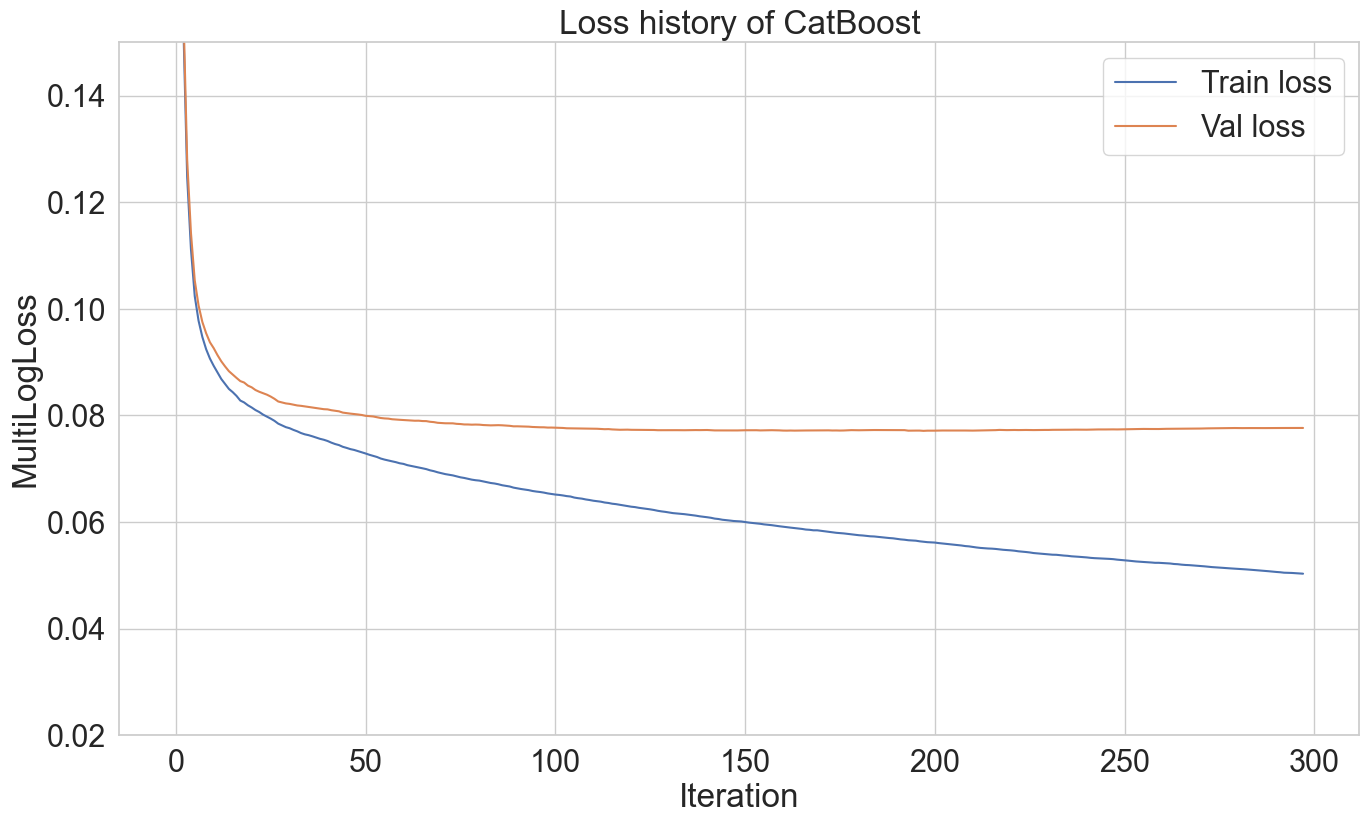

In [161]:
plt.figure(figsize=(16, 9))
plt.title("Loss history of CatBoost")
sns.lineplot(train_loss_history, label="Train loss")
sns.lineplot(val_loss_history, label="Val loss")
plt.xlabel("Iteration")
plt.ylabel("MultiLogLoss")
plt.ylim(0.02, 0.15)
plt.show()

In [214]:
y_test = best_catboost.predict(X_test_good_features)

In [236]:
for i in range(len(labels)):
    print(labels[i], f"{f1_score(y_test[:, i], y_pred[:, i]):.3f}", f"{accuracy_score(y_test[:, i], y_pred[:, i]):.3}")

VETER 0.698 0.998
SHKVAL 0.531 0.998
METEL 0.222 0.999
DOZD 0.886 0.964
SNEG 0.900 0.978
GRAD 0.000 1.0
TUMAN 0.823 0.996
GOLOLED 0.338 0.998


In [224]:
best_catboost.save_model("best_catboost.cbm")

In [217]:
feature_importances = best_catboost.feature_importances_

In [228]:
X_test_good_features.to_csv("X_test_good_features.csv", index=False)
pd.DataFrame(y_test, columns=labels).to_csv("y_test.csv", index=False)

In [221]:
np.argsort(-feature_importances)
for i in np.argsort(feature_importances):
    print(X_train.columns[i], feature_importances[i])

VV_median_window=8 0.0
Tn_isnan_has_nan_window=8 0.0
dd_changed_median_window=8 0.0
dd_changed_min_window=8 6.231295659495902e-05
VV_kurt_window=8 0.0006849400414092177
Tn_val_kurt_window=8 0.0007540981477991118
tR_std_window=8 0.004337824096468213
tR_mad_window=8 0.0046592348156854905
Tn_val_mean_window=8 0.005172206988420146
tR_mean_window=8 0.006965110086965242
Tx_val_mean_window=8 0.01467461345823363
Tx_isnan_mean_window=8 0.017855352394600895
Tx_isnan_median_window=8 0.020068151603227086
sss_has_nan_window=8 0.020779031290403253
Tn_isnan_min_window=8 0.026098387954460157
Tg_val_skew_window=8 0.04753901899050906
Ff_skew_window=8 0.04893203619797305
dd_y_rad_min_window=8 0.06333063407988933
dd_x_rad_mean_window=8 0.06414986196238963
dd_isnan_has_nan_window=8 0.065126599830634
T_skew_window=8 0.0658912588710009
dd_y_rad_has_nan_window=8 0.0695120568691689
VV_has_nan_window=8 0.07448991552547637
tR_count_window=8 0.07920304771036762
sss_count_window=8 0.08609522479975772
P_min_window=

# MLP

In [51]:
class WeatherMLP(pl.LightningModule):
    def __init__(self, d_in, d_layers, dropout, d_out):
        super().__init__()
        self.model = MLP.make_baseline(d_in, d_layers, dropout, d_out)
        self.criterion = nn.CrossEntropyLoss()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=1e-3)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        x, y = batch
        y_pred = self(x)

        loss = self.criterion(y_pred, y)

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)

        loss = self.criterion(y_pred, y)
        # f1 = metric_f.f1_score(torch.argmax(y_pred, -1), y, task="binary").item()

        self.log("val_loss", loss, prog_bar=True)

In [82]:
callbacks = [
    pl.callbacks.ModelCheckpoint("checkpoints/mlp"),
    pl.callbacks.EarlyStopping("val_loss", mode="max")
]

trainer = pl.Trainer(
    callbacks=callbacks, 
    gradient_clip_val=1.0,
    accelerator="mps", 
    devices=1,
    max_epochs=2
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [249]:
X_train_good_features

,T_median_window=8,T_max_window=8,Po_mean_window=8,Po_skew_window=8,Po_min_window=8,Po_max_window=8,P_mean_window=8,P_std_window=8,P_mad_window=8,P_skew_window=8,...,no_TUMAN_time,no_GOLOLED_time,P_year_ago,VV_year_ago,Td_year_ago,tR_year_ago,no_SHKVAL_time_year_ago,no_SNEG_time_year_ago,no_TUMAN_time_year_ago,no_GOLOLED_time_year_ago
0,0.00,0.0,0.0000,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.000000,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00,0.0,0.0000,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.000000,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.0,284.5000,0.516401,0.0,759.5,284.8125,393.078860,356.015625,0.516402,...,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3.95,0.0,379.6000,0.000012,0.0,760.8,380.0125,406.251289,380.012500,0.000012,...,3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-7.45,0.0,474.7625,-0.516374,0.0,761.3,475.2875,393.576994,356.465625,-0.516373,...,4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273863,25.60,31.3,746.2875,-0.038406,745.0,747.4,759.0500,1.171080,1.025000,0.127517,...,68,796,757.4,10.0,5.7,0.0,9.0,91.0,275.0,1097.0
273864,25.60,31.3,746.0625,0.420098,745.0,747.4,758.8000,1.021204,0.850000,0.534323,...,69,797,757.4,10.0,5.9,0.0,10.0,92.0,276.0,1098.0
273865,25.60,31.3,745.8625,0.800302,745.0,747.2,758.5750,0.757345,0.568750,0.567177,...,70,798,757.2,10.0,7.5,12.0,11.0,93.0,277.0,1099.0
273866,26.30,31.3,745.6750,1.066178,745.0,746.8,758.3875,0.535690,0.362500,0.461313,...,71,799,756.8,10.0,5.5,0.0,12.0,94.0,278.0,1100.0


In [251]:
cat_features_filtered

['Cm', 'Ch', "E'", 'RRR', 'Cl']

In [23]:
num_features_filtered = list(set(good_features) - set(cat_features_filtered))

In [19]:
oh_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_train_cat_oh = oh_encoder.fit_transform(X_train_good_features[cat_features_filtered])
X_val_cat_oh = oh_encoder.transform(X_val_good_features[cat_features_filtered])
X_test_cat_oh = oh_encoder.transform(X_test_good_features[cat_features_filtered])

In [28]:
X_train_merged = np.hstack([X_train_good_features[num_features_filtered].values, X_train_cat_oh])
X_val_merged = np.hstack([X_val_good_features[num_features_filtered].values, X_val_cat_oh])
X_test_merged = np.hstack([X_test_good_features[num_features_filtered].values, X_test_cat_oh])

In [30]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_merged)
X_val_scaled = scaler.transform(X_val_merged)
X_test_scaled = scaler.transform(X_test_merged)

In [61]:
def make_dataset(X, y, label_index, is_test=False):
    X = X.astype(float)
    dataset = []
    for i in range(len(X)):
        if is_test:
            dataset.append(
                torch.from_numpy(X[i]).float(),
            )
        else:
            dataset.append((
                torch.from_numpy(X[i]).float(),
                y[i, label_index]
            ))
    return dataset

In [33]:
labels

['VETER', 'SHKVAL', 'METEL', 'DOZD', 'SNEG', 'GRAD', 'TUMAN', 'GOLOLED']

In [93]:
results = []

for index, label in tqdm(enumerate(labels), total=len(labels)):
    print("Making model for", label)

    train_dataset = make_dataset(X_train_scaled, y_train, index)
    val_dataset = make_dataset(X_val_scaled, y_val, index)
    test_dataset = make_dataset(X_test_scaled, y_test, index, True)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    mlp_model = WeatherMLP(X_train_scaled.shape[1], [512, 512], 0.2, 2)    
    
    callbacks = [
        pl.callbacks.ModelCheckpoint("checkpoints/mlp"),
        pl.callbacks.EarlyStopping("val_loss", mode="max")
    ]

    trainer = pl.Trainer(
        callbacks=callbacks, 
        gradient_clip_val=1.0,
        accelerator="mps", 
        devices=1,
        max_epochs=2
    )

    trainer.fit(mlp_model, train_loader, val_loader)
    y_pred = trainer.predict(mlp_model, test_loader)
    y_pred_labels = torch.argmax(torch.cat(y_pred), -1).numpy()

    results.append({
        "label": label,
        "f1_score": f1_score(y_test[:, index], y_pred_labels),
        "accuracy_score": accuracy_score(y_test[:, index], y_pred_labels)
    })

  0%|          | 0/8 [00:00<?, ?it/s]

Making model for VETER


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MLP              | 423 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
423 K     Trainable params
0         Non-trainable params
423 K     Total params
1.696     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Predicting: 2140it [00:00, ?it/s]

Making model for SHKVAL


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /Users/shelbulat/Work/ForecastingExtremeWeather/notebooks/checkpoints/mlp exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MLP              | 423 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
423 K     Trainable params
0         Non-trainable params
423 K     Total params
1.696     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 2140it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

NaN or Inf found in input tensor.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 2140it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /Users/shelbulat/Work/ForecastingExtremeWeather/notebooks/checkpoints/mlp exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MLP              | 423 K 
1 | criterion | CrossEntropyLoss | 0     
------------

Sanity Checking: 0it [00:00, ?it/s]

/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 2140it [00:00, ?it/s]

Making model for SNEG


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /Users/shelbulat/Work/ForecastingExtremeWeather/notebooks/checkpoints/mlp exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MLP              | 423 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
423 K     Trainable params
0         Non-trainable params
423 K     Total params
1.696     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 2140it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 2140it [00:00, ?it/s]

Making model for TUMAN


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /Users/shelbulat/Work/ForecastingExtremeWeather/notebooks/checkpoints/mlp exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MLP              | 423 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
423 K     Trainable params
0         Non-trainable params
423 K     Total params
1.696     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 2140it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /Users/shelbulat/Work/ForecastingExtremeWeather/notebooks/checkpoints/mlp exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MLP              | 423 K 
1 | criterion | CrossEntropyLoss | 0     
------------

Sanity Checking: 0it [00:00, ?it/s]

/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
/Users/shelbulat/Work/ForecastingExtremeWeather/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 2140it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [99]:
pd.DataFrame(results).round(3).to_csv("mlp_results.csv", index=False)

In [97]:
for result in results:
    print(result["label"], f"{result['f1_score']:.3f}", f"{result['accuracy_score']:.3f}")

VETER 0.105 0.992
SHKVAL 0.011 0.990
METEL 0.046 0.997
DOZD 0.611 0.855
SNEG 0.532 0.903
GRAD 0.000 0.997
TUMAN 0.394 0.984
GOLOLED 0.000 0.994


Посмотрим loss history

In [128]:
class MetricsCallback(pl.Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_epoch_end(self, trainer, pl_module):
        result = {key: val.item() for key, val in trainer.callback_metrics.items()}
        self.metrics.append(result)

In [130]:
train_dataset = make_dataset(X_train_scaled, y_train, 3)
val_dataset = make_dataset(X_val_scaled, y_val, 3)
test_dataset = make_dataset(X_test_scaled, y_test, 3, True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

mlp_model = WeatherMLP(X_train_scaled.shape[1], [512, 512], 0.2, 2)    

callbacks = [
    pl.callbacks.ModelCheckpoint("checkpoints/mlp"),
    MetricsCallback()
]

trainer = pl.Trainer(
    callbacks=callbacks, 
    gradient_clip_val=1.0,
    accelerator="mps", 
    devices=1,
    max_epochs=10
)

trainer.fit(mlp_model, train_loader, val_loader)
y_pred = trainer.predict(mlp_model, test_loader)
y_pred_labels = torch.argmax(torch.cat(y_pred), -1).numpy()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MLP              | 423 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
423 K     Trainable params
0         Non-trainable params
423 K     Total params
1.696     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 2140it [00:00, ?it/s]

In [136]:
callbacks[1].metrics

[{'val_loss': 0.6565025448799133},
 {'train_loss': 0.34856298565864563, 'val_loss': 0.34848552942276},
 {'train_loss': 0.37793928384780884, 'val_loss': 0.34228846430778503},
 {'train_loss': 0.2789948880672455, 'val_loss': 0.3373417854309082},
 {'train_loss': 0.39125964045524597, 'val_loss': 0.33566218614578247},
 {'train_loss': 0.29311686754226685, 'val_loss': 0.3373487591743469},
 {'train_loss': 0.3251182734966278, 'val_loss': 0.3368564546108246},
 {'train_loss': 0.42446157336235046, 'val_loss': 0.3407706022262573},
 {'train_loss': 0.2265898585319519, 'val_loss': 0.3415967524051666},
 {'train_loss': 0.22905892133712769, 'val_loss': 0.33943337202072144},
 {'train_loss': 0.50113445520401, 'val_loss': 0.34295448660850525}]

In [163]:
data_plots = pd.DataFrame(callbacks[1].metrics)
train_loss_history = data_plots.train_loss
val_loss_history = data_plots.val_loss

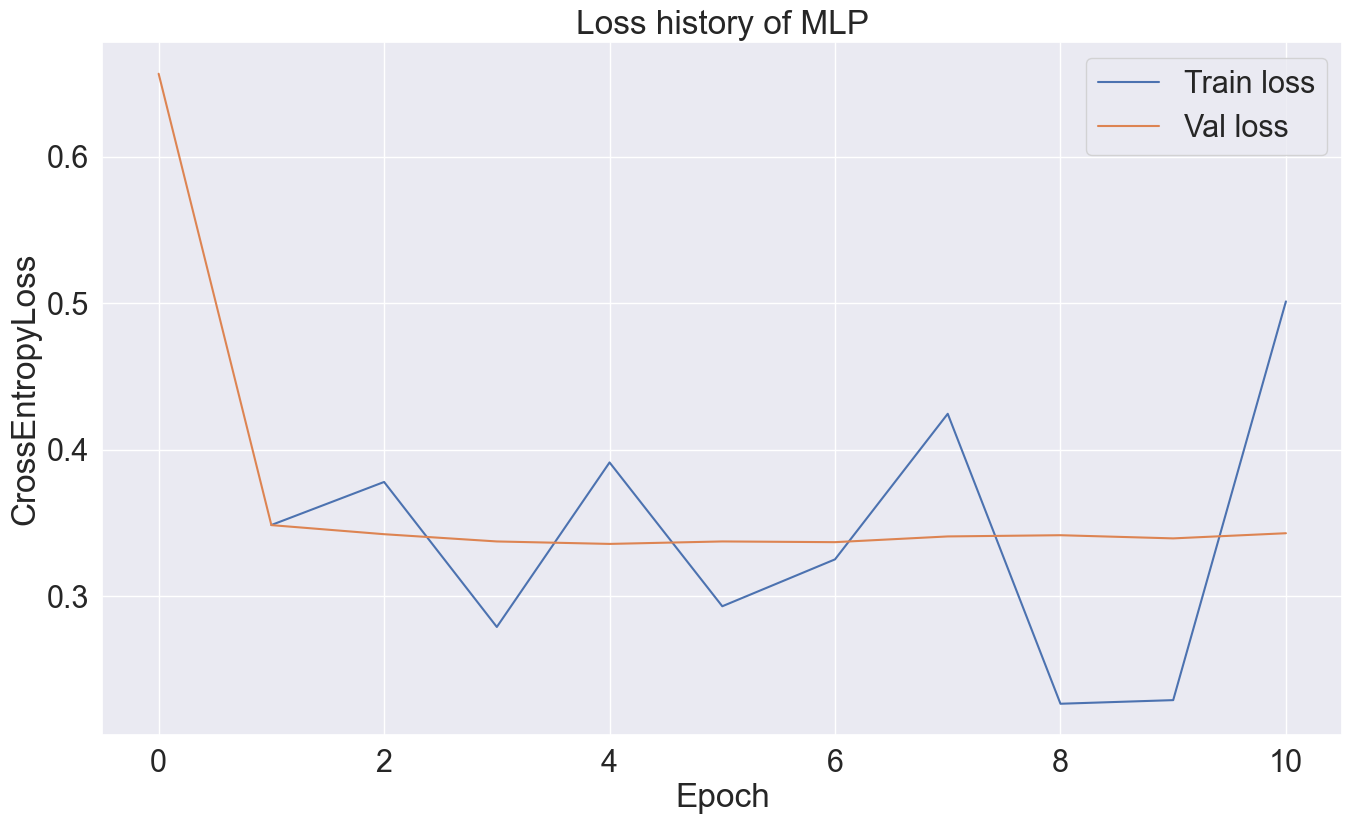

In [164]:
plt.figure(figsize=(16, 9))
plt.title("Loss history of MLP")
sns.lineplot(train_loss_history, label="Train loss")
sns.lineplot(val_loss_history, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropyLoss")
plt.show()